# Preparation

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_CLean.csv to data_CLean.csv


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
sns.set()

data = pd.read_csv("data_CLean.csv", sep='\t')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = data.rename(columns={'image': 'images'}).drop("Unnamed: 0", axis=1)

In [ ]:
data

,product_category_tree,images,description,Cat_0,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6
0,Home Furnishing >> Curtains & Accessories >> C...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN
1,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y",NaN,NaN
2,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE FA,NaN,NaN
3,Home Furnishing >> Bed Linen >> Bedsheets >> S...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King sized,NaN,NaN
4,Home Furnishing >> Bed Linen >> Bedsheets >> J...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double Bed,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1045,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,NaN,NaN,NaN
1046,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,NaN,NaN,NaN
1047,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,NaN,NaN,NaN
1048,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,NaN,NaN,NaN


## __Images__ traitement 

In [ ]:
def to_list_images(df):
    prefixe = "Images/"+ df
    return(prefixe.to_list())

images_adress = to_list_images(data["images"])


(460, 694, 4)
(224, 224)


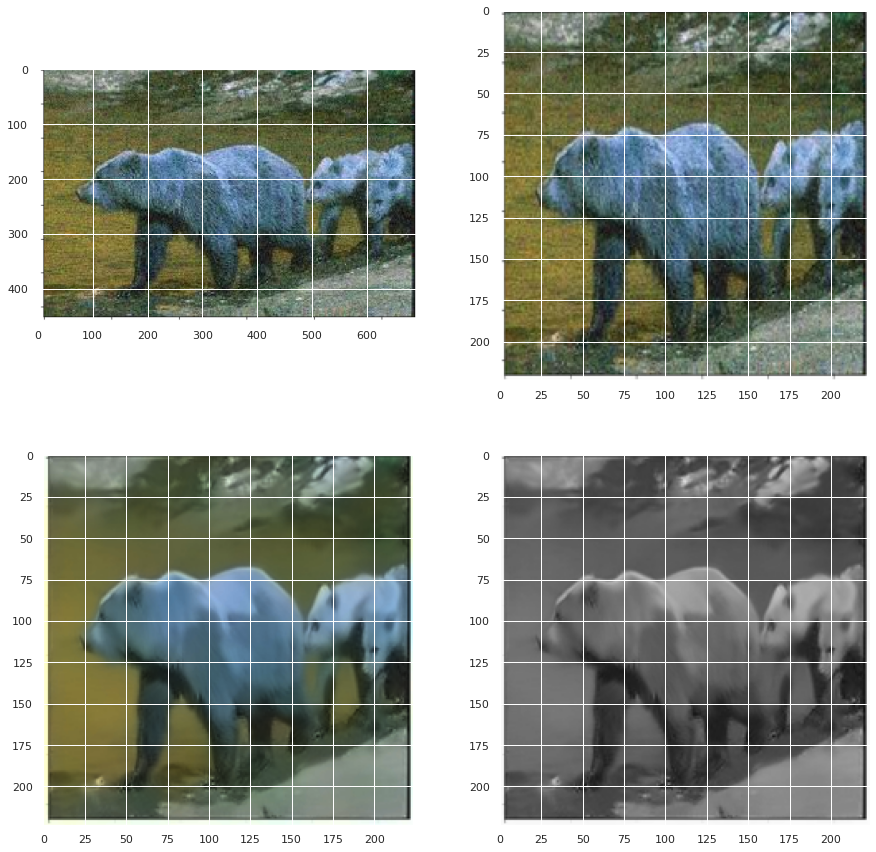

In [ ]:

import cv2
from PIL import Image

image = "bear.png"
img      = Image.open(image)
img_rs      = img.resize((224,224),Image.ANTIALIAS)
#     img = cv2.imread(image)
print(np.shape(np.array(img)))
dst = cv2.fastNlMeansDenoisingColored(np.array(img_rs),None,10,10,7,21)
#     img      = Image.open(image)
img_dst = Image.fromarray(dst)
img_nb   =  img_dst.convert('F')

print(np.shape(np.array(img_nb)))



fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes[0,0].imshow(img)
axes[0,1].imshow(img_rs)
axes[1,0].imshow(dst)
axes[1,1].imshow(img_nb)

## __Images__ 

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline

from sklearn import manifold
import seaborn as sns

from scipy.sparse import csr_matrix, isspmatrix

def kmeans_label(X_Std,num_clusters,stab ) : 
    cls = KMeans(n_clusters=num_clusters, random_state=stab)
    print("AVANT FIT num_clusters,stab", num_clusters,stab)
    cls.fit(X_Std)
#     print("APRES FIT num_clusters,stab", num_clusters,stab)
    lab = cls.labels_
    del cls
    return lab

def silhouette(X_Std, K_min,K_max,K_pas, max_it) : 
    silhouettes = []
    for num_clusters in range(K_min,K_max,K_pas) : 
        print("Nombre de clusters : {}".format(num_clusters))
        for stab in range(max_it) :
    #         n_init = 10
#             cls = KMeans(n_clusters=num_clusters, random_state=stab)
#             cls.fit(X_Std)
            silh = metrics.silhouette_score(X_Std, kmeans_label(X_Std,num_clusters,stab))
            silhouettes.append([num_clusters, stab, "n_init",silh])
    
    return silhouettes
    
def plot_silhouette(silhouettes) :
    
    df = pd.DataFrame(silhouettes,
                      columns=["K","random_state"    ,"n_init", "silhouettes"])

    sns.set(style="whitegrid")
    
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    ax = sns.boxplot(x="K", y="silhouettes",
                     data=df)
    
    
    idxmax = df.silhouettes.idxmax()
    score_max = df.silhouettes[idxmax]
    best_random_state = df.random_state[idxmax]
    bestCluster = df.K[idxmax]
    
    return [idxmax,score_max, best_random_state, bestCluster ]
    
    
    
    
    
def plot_TSNE(X_Std, TSNE_per, n_clusters, sample_silhouette_values, cluster_labels, silhouette_avg) : 
    
    for perplexity in TSNE_per : 

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        # ax1.set_ylim([0, len(X_Std) + (n_clusters + 1) * 10])

        y_lower = 10

        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed

        embedding = manifold.TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca')


        X_transformed = embedding.fit_transform(X_Std)

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
    
    
    
    
    
def kMeans_func(X,K_min=10,K_max=55,K_pas=5, TSNE_per=[10], norm="norm") : 
    
    if isspmatrix(X) : Xdense = X.todense()
    else : Xdense = X.copy()
        
    if norm == "stand" : 
        scaler_VW = StandardScaler()
        X_Std=scaler_VW.fit_transform(Xdense)
    else :
        X_Std=normalize(Xdense, copy=False)
    
    max_it=3

    silhouettes = silhouette(X_Std, K_min,K_max,K_pas, max_it)
    
    [idxmax,score_max, best_random_state, bestCluster ] = plot_silhouette(silhouettes)
    
    print("score_max", score_max, bestCluster)
    
    print(__doc__)

    clusterer = KMeans(n_clusters=bestCluster, random_state=best_random_state)
    cluster_labels = clusterer.fit_predict(X_Std)

    silhouette_avg = silhouette_score(X_Std, cluster_labels)
    print("For bestCluster =", bestCluster,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X_Std, cluster_labels)

    plot_TSNE(X_Std, TSNE_per, bestCluster, sample_silhouette_values, cluster_labels, silhouette_avg)
    
    return cluster_labels
    

# __Split__ data train & test

## répartition des données

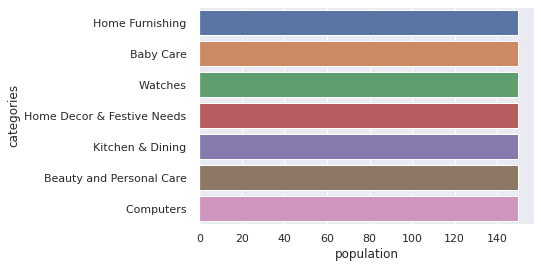

In [ ]:
categs = data["Cat_0"].unique()
repartition = []
for categ in categs : 
    
    
    repartition.append( [categ,data.loc[ data["Cat_0"]==categ]["Cat_0"].shape[0]])
df = pd.DataFrame(repartition, columns = ["categories", "population"])
sns.barplot(x="population", y = "categories" ,   data=df)

## split data train & test

### Stratification split

In [ ]:
from sklearn.model_selection import train_test_split

corpus_col = "description"

numerical_features = []
categorical_features = [corpus_col]


X = data[numerical_features + categorical_features]
y = data["Cat_0"]

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)

X_train :  (840, 1)
X_test :  (210, 1)
y_train :  (840,)
y_test :  (210,)


In [ ]:
X_train["images"] =  "Images/"+ data["images"]
X_test["images"] =  "Images/"+ data["images"]


In [ ]:

#X_train["img224"]  = data["img224"]
#X_test["img224"]  = data["img224"]

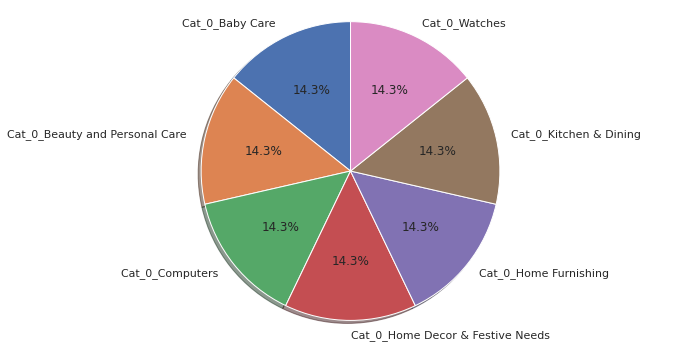

In [ ]:
y_train_images = y_train.to_frame()
y_train_images

colQualiTest = "Cat_0"
df = y_train_images

from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()

ohe = ohc.fit_transform(df[colQualiTest].values.reshape(-1,1)).toarray()
results = pd.DataFrame(ohe, columns = [colQualiTest +"_"+ str(ohc.categories_[0][i]) 
                                       for i in range(len(ohc.categories_[0]) )], index = df.index)
results = results.replace(0, np.nan)
labels = results.columns.to_list()
sizes = results.count().to_list()

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()


results = results.replace(np.nan, 0)
y_train_images = results

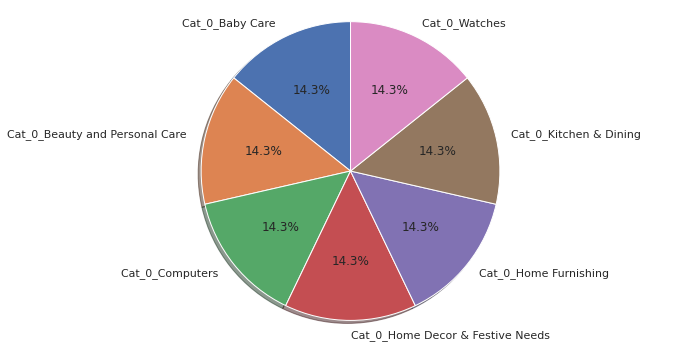

In [ ]:
y_test_images = y_test.to_frame()
y_test_images

colQualiTest = "Cat_0"
df = y_test_images

from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()

ohe = ohc.fit_transform(df[colQualiTest].values.reshape(-1,1)).toarray()
results = pd.DataFrame(ohe, columns = [colQualiTest +"_"+ str(ohc.categories_[0][i]) 
                                       for i in range(len(ohc.categories_[0]) )], index = df.index)
results = results.replace(0, np.nan)
labels = results.columns.to_list()
sizes = results.count().to_list()

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()


results = results.replace(np.nan, 0)
y_test_images = results

# __Pre-processing__ supervisee

## Numerical pipeline pre-processing

### __Images__ preprocesing

#### bag of VW

#### Keras

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

def pre_Keras(X) :
#     X_v2= pd.DataFrame(X["images"], columns = ["images"])
        
    return np.array([img_to_array(load_img(img, target_size=(224, 224)))
                               for img in X['images'].values.tolist()
                          ]).astype('float32') 
    

Using TensorFlow backend.


### __Export__ CSV pour qualif images

### categorical_pipeline finale

# Classification avec les images

## Keras

### Kfold  cross propagation

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(5, shuffle=True, random_state=42) 

oos_y = []
oos_pred = []
fold = 0

x = pre_Keras(X_train)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
dummies = pd.get_dummies(y_train) # Classification
y = dummies.values
np.shape(y)

(840, 7)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.layers import Dense, Flatten
from keras import Model
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import os

oos_y = []
oos_pred = []
fold = 0

# Entraîner sur les données d'entraînement (X_train, y_train)
# model_info = new_model.fit(X_train_preimg_Keras, y_train_images, epochs=7, verbose=2)


# Must specify y StratifiedKFold for
for train, test in kf.split(x,y_train):  
    fold+=1
    print(f"Fold #{fold}")
        
    xfold_train = x[train]
    yfold_train = y[train]
    xfold_test = x[test]
    yfold_test = y[test]
  
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    model = VGG16() # Création du modèle VGG-16 implementé par Keras
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # les couches sont pré-entrainée (on n'entraine pas les couches intermédiaires)
    for layer in model.layers:
       layer.trainable = False
    # Récupérer la sortie de ce réseau
    x_sortie_net = Flatten()(model.output)
    # Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
    predictions = Dense(7, activation='softmax')(x_sortie_net)
    # Définir le nouveau modèle
    new_model = Model(inputs=model.input, outputs=predictions)
    
    
    new_model.compile(loss="categorical_crossentropy", 
                      optimizer='adam', 
                      metrics=["accuracy"])
    
#     Early stopping
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, 
            verbose=1, mode='auto', restore_best_weights=True)
       
    new_model.fit(xfold_train,yfold_train,validation_data=(xfold_test,yfold_test),
        callbacks=[monitor], verbose=0,epochs=9)
    
    pred = new_model.predict(xfold_test)
    
    oos_y.append(yfold_test)
    # raw probabilities to chosen class (highest probability)
    pred = np.argmax(pred,axis=1) 
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(yfold_test,axis=1) # For accuracy calculation
    score = accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {score}", score)
    
    save_path = "."
    model_save = "model_{}.h5".format(fold)
    model.save(os.path.join(save_path,model_save))
    

Fold #1
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Fold score (accuracy): {score} 0.8333333333333334
Fold #2
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
Fold score (accuracy): {score} 0.7619047619047619
Fold #3
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
Fold score (accuracy): {score} 0.7738095238095238
Fold #4
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Fold score (accuracy): {score} 0.7797619047619048
Fold #5
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
Fold score (accuracy): {score} 0.7976190476190477


In [ ]:
(4+3+3+7+3)/5

4.0

In [ ]:
oos_y_label = []
oos_y_OHE = []
for k in range(5) : 
    print(k)
    oos_y_label.append(np.argmax(oos_y[k],axis=1))
    oos_y_OHE.append([oos_y[k]])
    
print(np.shape(oos_y_OHE))

df = pd.DataFrame(oos_y_label)
df.to_csv('oos_y_label.csv', sep='\t', encoding='utf-8')

df = pd.DataFrame(oos_y_OHE)
df.to_csv('oos_y_OHE.csv', sep='\t', encoding='utf-8')

df = pd.DataFrame(oos_pred)
df.to_csv('oos_pred.csv', sep='\t', encoding='utf-8')

0
1
2
3
4
(5, 1, 168, 7)


In [ ]:
oos_y_label = pd.read_csv("oos_y_label.csv", sep='\t')
oos_y_OHE = pd.read_csv("oos_y_OHE.csv", sep='\t')
oos_pred = pd.read_csv("oos_pred.csv", sep='\t')

y_true = np.concatenate(oos_y_label.drop("Unnamed: 0", axis=1).values)
y_pred= np.concatenate(oos_pred.drop("Unnamed: 0", axis=1).values)

col = [0,0,0,0,0,0,0]
y_true_OHE = []
y_pred_OHE = []

for k in y_true : 
    col[k] = 1
    y_true_OHE.append(col)
    col = [0,0,0,0,0,0,0]
    
col = [0,0,0,0,0,0,0]   
for k in y_pred : 
    col[k] = 1
    y_pred_OHE.append(col)
    col = [0,0,0,0,0,0,0]

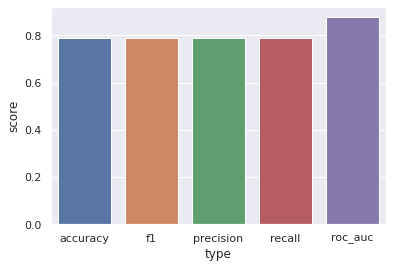

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

score_keras = []
score_keras.append(["accuracy", accuracy_score(y_pred, y_true)])
score_keras.append(["f1", f1_score(y_pred, y_true, average="weighted")])
score_keras.append(["precision", precision_score(y_pred, y_true, average="weighted")])
score_keras.append(["recall", recall_score(y_pred, y_true, average="weighted")])
score_keras.append(["roc_auc", roc_auc_score(y_true_OHE, y_pred_OHE, multi_class = "ovr" , 
                                 average="weighted" )])

df = pd.DataFrame(score_keras, columns = ["type", "score"])
sns.barplot(x="type", y="score", data=df)

### Retrain sur tous le set 

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16() # Création du modèle VGG-16 implementé par Keras

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
import tensorflow as tf

from sklearn.pipeline import Pipeline


# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
   layer.trainable = False

# Récupérer la sortie de ce réseau
x = Flatten()(model.output)

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
predictions = Dense(7, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

# Compiler le modèle 
from keras import optimizers

X_train_preimg_Keras = pre_Keras(X_train)

# Entraîner sur les données d'entraînement (X_train, y_train)

new_model.compile(loss="categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["accuracy"])

new_model.fit(X_train_preimg_Keras, y_train_images, epochs=4, verbose=2)



/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch 1/4
 - 390s - loss: 15.5802 - accuracy: 0.6429
Epoch 2/4
 - 389s - loss: 1.9896 - accuracy: 0.9440
Epoch 3/4
 - 391s - loss: 0.2711 - accuracy: 0.9881
Epoch 4/4
 - 391s - loss: 0.1516 - accuracy: 0.9917


In [ ]:
import os
save_path = "."
model_save = "model_vgg16.h5"
new_model.save(os.path.join(save_path,model_save))

In [ ]:
import os
save_path = "."
from tensorflow.keras.models import load_model
model2 = load_model(os.path.join(save_path,"model_vgg16.h5"))
# pred = model2.predict(x)
# # Measure RMSE error.  RMSE is common for regression.
# score = np.sqrt(metrics.mean_squared_error(pred,y))
# print(f"After load score (RMSE): {score}")

### Results test

In [ ]:
X_test_preimg_Keras = pre_Keras(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred_keras = model2.predict(X_test_preimg_Keras)
y_pred_test_images = y_test_images.copy()
y_pred_test_images.loc[:,:] = y_pred_keras

y_pred_str = y_pred_test_images.idxmax( axis=1).str.split("Cat_0_", expand=True).drop(0, axis=1)[1]
y_true_str = y_test



In [ ]:

# np.save('y_pred_test_str',y_pred_str.values )
# np.save('y_true_test_str',y_true_str.values )
y_pred_str.to_csv("y_pred_test_str.csv")
y_true_str.to_csv("y_true_test_str.csv")
np.save('y_pred_test_OHE',y_pred_keras )
np.save('y_true_test_OHE',y_test_images )

In [ ]:
# y_pred_str = np.load('y_pred_test_str.npy')
# y_true_str = np.load('y_true_test_str.npy')
y_pred_str_read = pd.read_csv("y_pred_test_str.csv")
y_true_str_read = pd.read_csv("y_true_test_str.csv")
y_pred_keras = np.load('y_pred_test_OHE.npy')
y_test_images = np.load('y_true_test_OHE.npy')

y_pred_str_read
y_pred_str_read.index = y_pred_str_read["Unnamed: 0"]
y_pred_str = y_pred_str_read.drop("Unnamed: 0", axis=1)["1"]

y_true_str_read
y_true_str_read.index = y_true_str_read["Unnamed: 0"]
y_true_str_read
y_true_str = y_true_str_read.drop("Unnamed: 0", axis=1)




In [ ]:
score_keras = []
score_keras.append(["accuracy", accuracy_score(y_pred_str, y_true_str)])
score_keras.append(["f1", f1_score(y_pred_str, y_true_str, average="weighted")])
score_keras.append(["precision", precision_score(y_pred_str, y_true_str, average="weighted")])
score_keras.append(["recall", recall_score(y_pred_str, y_true_str, average="weighted")])
score_keras.append(["roc_auc", roc_auc_score(y_test_images, y_pred_keras, multi_class = "ovr" , 
                                 average="weighted" )])


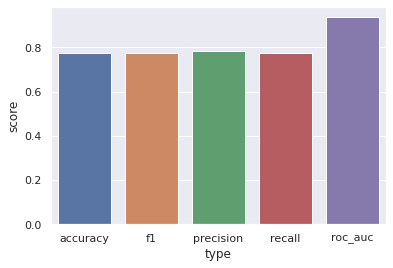

In [ ]:
df = pd.DataFrame(score_keras, columns = ["type", "score"])
sns.barplot(x="type", y="score", data=df)

### Confusion matrice

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix_output =multilabel_confusion_matrix(y_true_str, y_pred_str, labels = y_true_str["Cat_0"].unique()) 

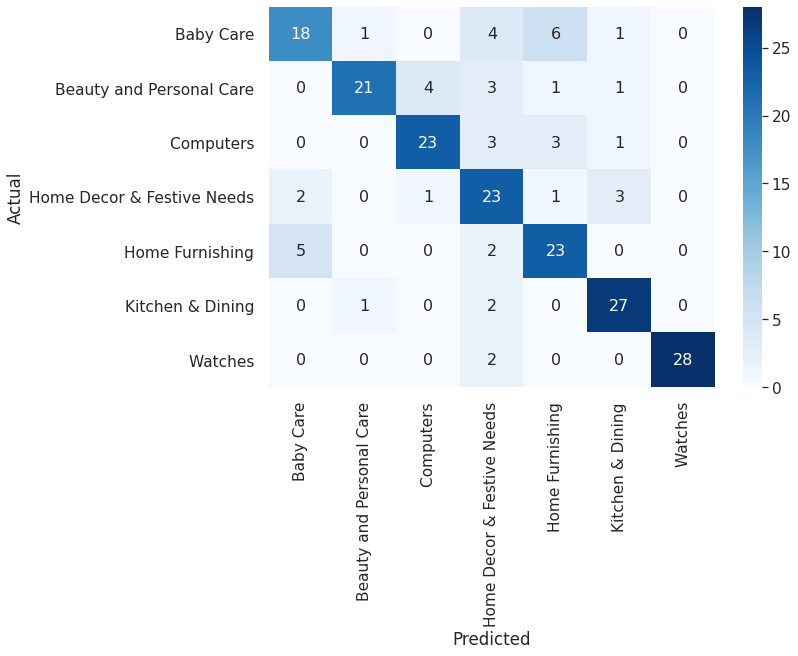

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

confusion_matrix_output = confusion_matrix(y_true_str, y_pred_str)
df_cm = pd.DataFrame(confusion_matrix_output, columns=np.unique(y_true_str), index = np.unique(y_true_str))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

# Segmentation images

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

from sklearn import manifold
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
    
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.sparse import csr_matrix, isspmatrix

def kmeans_label(X_Std,num_clusters,stab ) : 
    cls = KMeans(n_clusters=num_clusters, random_state=stab)
    print("AVANT FIT num_clusters,stab", num_clusters,stab)
    cls.fit(X_Std)
#     print("APRES FIT num_clusters,stab", num_clusters,stab)
    lab = cls.labels_
    del cls
    return lab

def silhouette(X_Std, K_min,K_max,K_pas, max_it) : 
    silhouettes = []
    for num_clusters in range(K_min,K_max,K_pas) : 
        print("Nombre de clusters : {}".format(num_clusters))
        for stab in range(max_it) :
    #         n_init = 10
#             cls = KMeans(n_clusters=num_clusters, random_state=stab)
#             cls.fit(X_Std)
            silh = metrics.silhouette_score(X_Std, kmeans_label(X_Std,num_clusters,stab))
            silhouettes.append([num_clusters, stab, "n_init",silh])
    
    return silhouettes
    
def plot_silhouette(silhouettes) :
    
    df = pd.DataFrame(silhouettes,
                      columns=["K","random_state"    ,"n_init", "silhouettes"])

    sns.set(style="whitegrid")
    
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    ax = sns.boxplot(x="K", y="silhouettes",
                     data=df)
    
    
    idxmax = df.silhouettes.idxmax()
    score_max = df.silhouettes[idxmax]
    best_random_state = df.random_state[idxmax]
    bestCluster = df.K[idxmax]
    
    return [idxmax,score_max, best_random_state, bestCluster ]
    
    
    
    
    
def plot_TSNE(X_Std, TSNE_per, n_clusters, sample_silhouette_values, cluster_labels, silhouette_avg, init_TSNE) : 
    
    for perplexity in TSNE_per : 

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        # ax1.set_ylim([0, len(X_Std) + (n_clusters + 1) * 10])

        y_lower = 10

        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed

        embedding = manifold.TSNE(n_components=2, perplexity=perplexity, random_state=42, init=init_TSNE)


        X_transformed = embedding.fit_transform(X_Std)

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
    
    
    
    
    
def kMeans_func(X,K_min=10,K_max=55,K_pas=5, TSNE_per=[10], norm="norm", init_TSNE="pca") : 
    
    if isspmatrix(X) : Xdense = X.todense()
    else : Xdense = X.copy()
        
    if norm == "stand" : 
        scaler_VW = StandardScaler()
        X_Std=scaler_VW.fit_transform(Xdense)
    else :
        X_Std=normalize(Xdense, copy=False)
    
    max_it=3

    silhouettes = silhouette(X_Std, K_min,K_max,K_pas, max_it)
    
    [idxmax,score_max, best_random_state, bestCluster ] = plot_silhouette(silhouettes)
    
    print("score_max", score_max, bestCluster)
    
    print(__doc__)

    clusterer = KMeans(n_clusters=bestCluster, random_state=best_random_state)
    cluster_labels = clusterer.fit_predict(X_Std)

    silhouette_avg = silhouette_score(X_Std, cluster_labels)
    print("For bestCluster =", bestCluster,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X_Std, cluster_labels)

    plot_TSNE(X_Std, TSNE_per, bestCluster, sample_silhouette_values, cluster_labels, silhouette_avg,init_TSNE )
    
    return cluster_labels
    
    

def dbscan_func(X,epsi=0.5,min_samples=2,K_pas=5, TSNE_per=[10], norm="norm", init_TSNE="pca") : 
    
    if isspmatrix(X) : Xdense = X.todense()
    else : Xdense = X.copy()
        
    if norm == "stand" : 
        scaler_VW = StandardScaler()
        X_Std=scaler_VW.fit_transform(Xdense)
    else :
        X_Std=normalize(Xdense, copy=False)
    
    max_it=3
    
    db = DBSCAN(eps=0.5, min_samples=2).fit(XStd)

    cluster_labels = db.labels_
    
    sample_silhouette_values = silhouette_samples(XStd, cluster_labels)
    
    silhouette_avg = silhouette_score(XStd, cluster_labels)

    print("silhouette_avg", silhouette_avg)

#     plot_TSNE(XStd, [10], 8, sample_silhouette_values, cluster_labels, silhouette_avg, "pca")
    
    
    
#     cluster_labels = DBSCAN(eps=epsi, min_samples=2).fit(XStd)
#     print("avant plot_TSNE_simple", cluster_labels)
#     print("avant plot_TSNE_simple", init_TSNE)
#     print("avant plot_TSNE_simple", cluster_labels)
    plot_TSNE_simple(X_Std, TSNE_per, cluster_labels,  init_TSNE)
    
    return cluster_labels
    

def plot_TSNE_simple(X_Std, TSNE_per, cluster_labels,init_TSNE) : 
    print(TSNE_per)
    
    

    
    
    
    
    for perplexity in TSNE_per : 
        print("perplexity", perplexity)
        fig, ax2 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)
       
        y_lower = 10
        # 2nd Plot showing the actual clusters formed

        embedding = manifold.TSNE(n_components=2, perplexity=perplexity, random_state=42, init=init_TSNE)

        X_transformed = embedding.fit_transform(X_Std)

        colors = cm.nipy_spectral(cluster_labels.astype(float) )

        ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")


        plt.show()

silhouette_avg -0.28522892235949704
[10]
perplexity 10


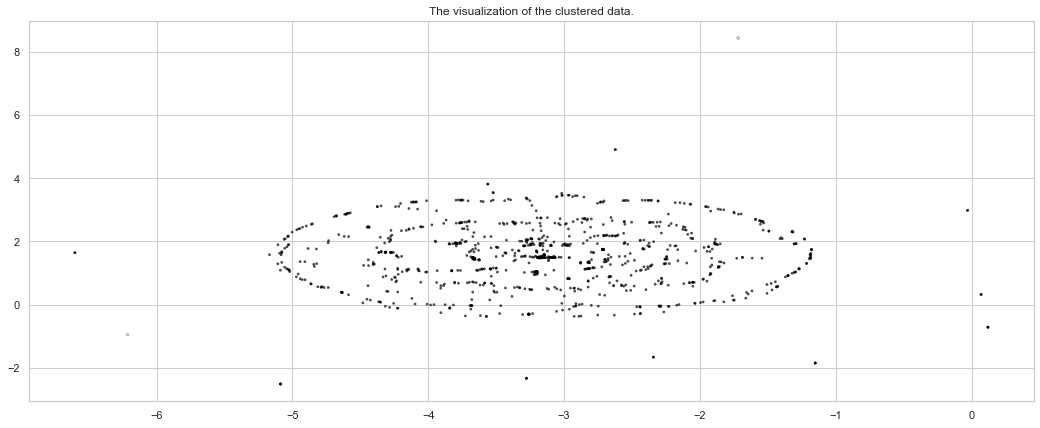

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [ ]:
dbscan_func(X_VW.loc[:, "VW_0":],epsi=0.3,min_samples=2,K_pas=5, TSNE_per=[10], norm="norm", init_TSNE="pca")

## VW

In [ ]:
# X_train_images_bgVW = X_images_bag_of_VW.loc[X_train.index.to_list()]
# X_test_images_bgVW = X_images_bag_of_VW.loc[X_test.index.to_list()]

X_test_images_bgVW = creation_bag_of_VW_noscale(data,nb_VW=6000)

features done
kmeans done
compact done
mise en forme done


In [ ]:
X_test_images_bgVW.to_csv('X_test_images_bgVW.csv', sep='\t', encoding='utf-8')

In [ ]:
X_VW = pd.read_csv("X_test_images_bgVW.csv", sep='\t')

Nombre de clusters : 8
AVANT FIT num_clusters,stab 8 0
AVANT FIT num_clusters,stab 8 1
AVANT FIT num_clusters,stab 8 2
Nombre de clusters : 9
AVANT FIT num_clusters,stab 9 0
AVANT FIT num_clusters,stab 9 1
AVANT FIT num_clusters,stab 9 2
Nombre de clusters : 10
AVANT FIT num_clusters,stab 10 0
AVANT FIT num_clusters,stab 10 1
AVANT FIT num_clusters,stab 10 2
Nombre de clusters : 11
AVANT FIT num_clusters,stab 11 0
AVANT FIT num_clusters,stab 11 1
AVANT FIT num_clusters,stab 11 2
score_max 0.005794345603422182 8
Automatically created module for IPython interactive environment
For bestCluster = 8 The average silhouette_score is : 0.005794345603422182


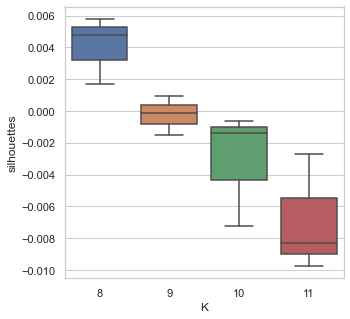

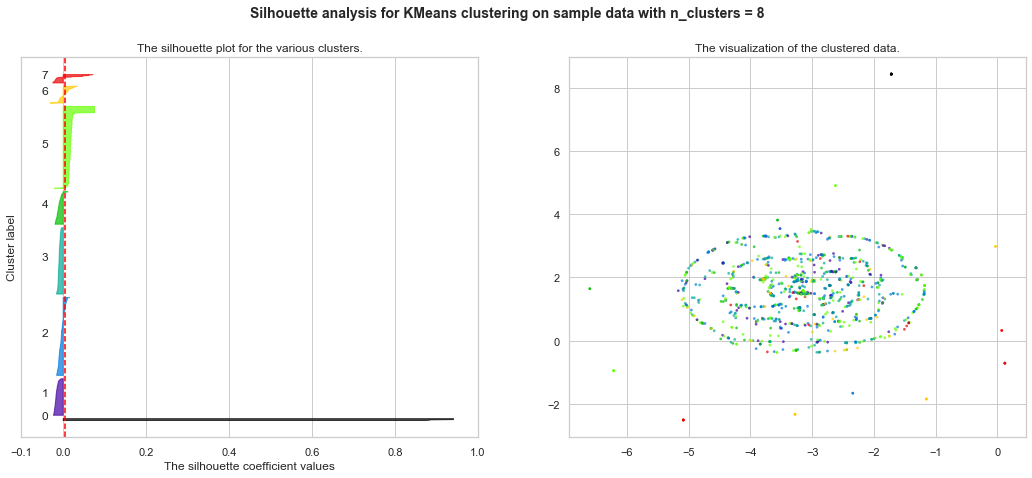

array([1, 4, 3, ..., 3, 5, 3])

In [ ]:
kMeans_func(X_VW.loc[:, "VW_0":],K_min=8,K_max=12,K_pas=1, TSNE_per=[10], norm="norm", init_TSNE="pca")

silhouette_avg -0.28522892235949704


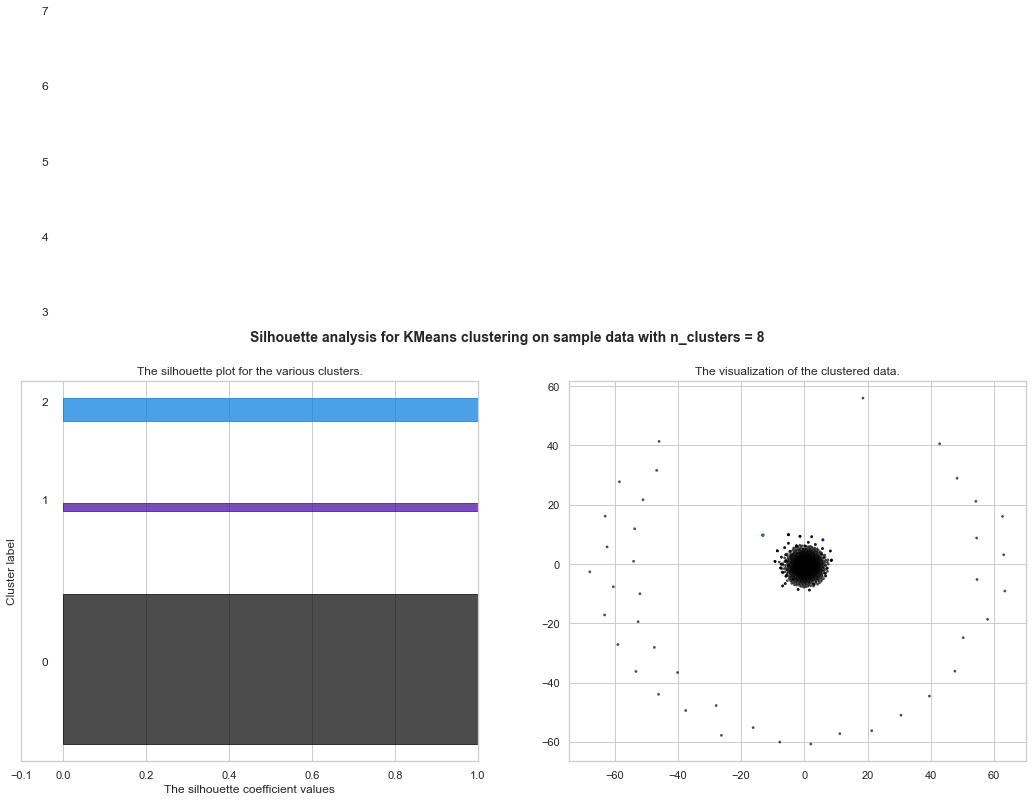

In [ ]:
from sklearn.cluster import DBSCAN

XStd = X_VW.loc[:, "VW_0":]
db = DBSCAN(eps=0.5, min_samples=2).fit(XStd)

cluster_labels = db.labels_
sample_silhouette_values = silhouette_samples(XStd, cluster_labels)
silhouette_avg = silhouette_score(XStd, cluster_labels)

print("silhouette_avg", silhouette_avg)

plot_TSNE(XStd, [10], 8, sample_silhouette_values, cluster_labels, silhouette_avg, "pca")

## VGG16

### extraction features

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16() 

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
import tensorflow as tf

from sklearn.pipeline import Pipeline

model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
all_set = data.copy()
all_set["images"]  =    "Images/"+ data["images"]

In [1]:
# # X_test_preimg_Keras = pre_Keras(X_test.loc[0].to_frame().T)
X_test_preimg_Keras = pre_Keras(all_set)

vgg16_feature = model.predict(X_test_preimg_Keras)

# # y_pred_keras = new_model.predict(X_test_preimg_Keras)

In [ ]:
vgg16_feature_list = []
for vgg in vgg16_feature : 
    vgg16_feature_np = np.array(vgg)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
np.shape(vgg16_feature_list)

### Kmeans

Nombre de clusters : 11
AVANT FIT num_clusters,stab 11 0
AVANT FIT num_clusters,stab 11 1
AVANT FIT num_clusters,stab 11 2
score_max 0.052314670232857144 11
Automatically created module for IPython interactive environment
For bestCluster = 11 The average silhouette_score is : 0.052314670232857144


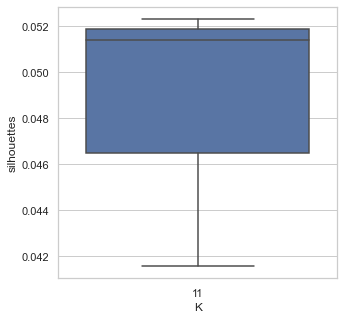

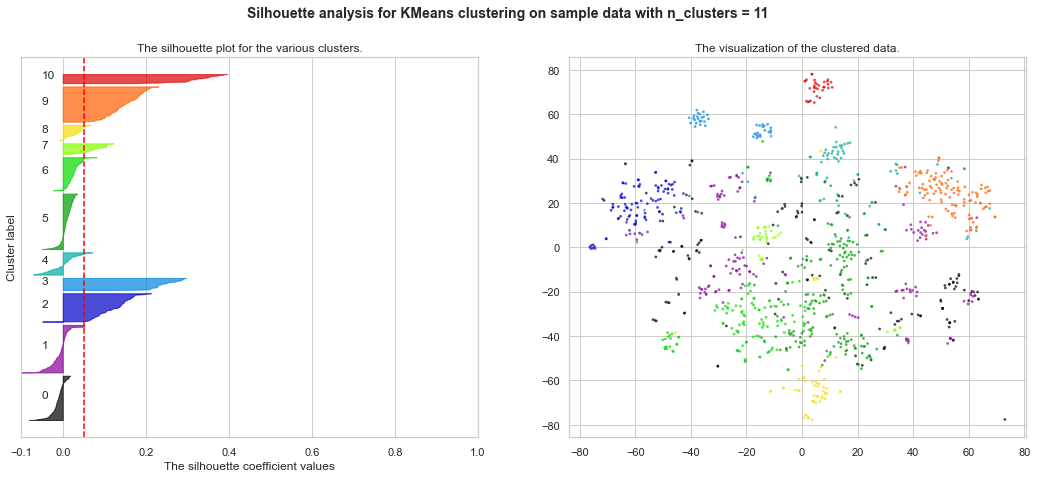

array([6, 5, 6, ..., 0, 0, 0])

In [ ]:

kMeans_func(vgg16_feature_list,K_min=11,K_max=12,K_pas=1, norm="norm")

Nombre de clusters : 11
AVANT FIT num_clusters,stab 11 0
AVANT FIT num_clusters,stab 11 1
AVANT FIT num_clusters,stab 11 2
score_max 0.05231467023430617 11
Automatically created module for IPython interactive environment
For bestCluster = 11 The average silhouette_score is : 0.05231467023430617


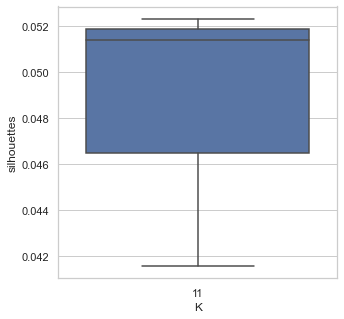

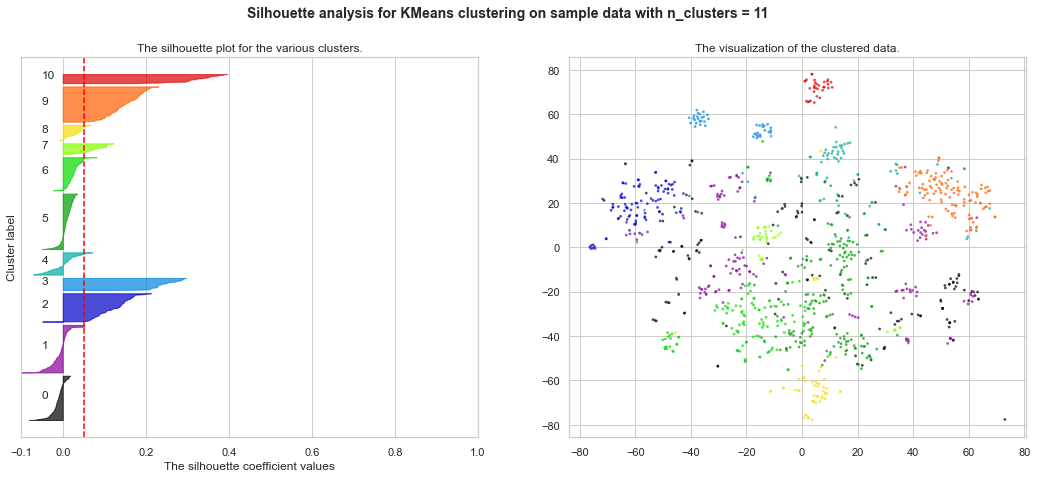

array([6, 5, 6, ..., 0, 0, 0])

In [ ]:
# scalling = normalize(X_images_bag_of_VW.loc[:,"VW_0":], copy=False)

kMeans_func(normalize(vgg16_feature_list),K_min=11,K_max=12,K_pas=1, norm="norm")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from matplotlib import offsetbox


# fonction pour afficher une partie des images sur la visualisation 2D
def plot_embedding(X, images, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(len(X)):
            if i%100 == 0 : print(i)
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 2e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            props={ 'boxstyle':'round', 'edgecolor':'white'}
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=plt.cm.gray, zoom=0.15), 
                                                X[i], bboxprops=props)
            ax.add_artist(imagebox)
    if title is not None:
        plt.title(title)

In [2]:
XStd = vgg16_feature_list
images = img_pre_arr



X = XStd
tsne = manifold.TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, images, "Principal Components projection of the digits")
plt.show()

In [ ]:
XStd = vgg16_feature_list
images = img_pre_arr



X = XStd
tsne = manifold.TSNE(n_components=2, random_state=42, init='pca' )
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, images, "Principal Components projection of the digits")
plt.show()

### reduction PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)

image_features = pca.fit_transform(vgg16_feature_list)

In [ ]:
np.shape(image_features)

In [ ]:

kMeans_func(normalize(image_features),K_min=8,K_max=12,K_pas=1, norm="norm")